## Load/import packages

In [1]:
import json
import scipy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import kerastuner as kt

from tensorflow.keras import Sequential, layers
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.utils import class_weight

from os import listdir
from os.path import join, splitext, normpath

# Import variables and functions from my own scripts
from functions import f1, plot_history, arr_replacevalue
from load_features import (
    train_features_AW2,
    val_features_AW2,
    train_labels_AW2,
    val_labels_AW2,
    labels_reshaper,
    features_reshaper,
)

%matplotlib inline

# Limit GPU memory usage
for device in tf.config.experimental.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(device, True)

# Prepare data

## Reshape features, labels
The model gets more unstable and validation scores converge later with higher sequence length. Increasing sequence length does not improve the models performance.

In [2]:
# Reshape data to specified sequence length
length = 60
seq_train_features = features_reshaper(train_features_AW2, length)
seq_val_features = features_reshaper(val_features_AW2, length)

seq_train_labels = labels_reshaper(train_labels_AW2, length)
seq_val_labels = labels_reshaper(val_labels_AW2, length)

## Compute sample weights

In [3]:
def comp_sampleweights(labels):
    # Convert one-hot encoded labels back to label integers
    train_label_ints = np.argmax(labels, axis=2)

    # Compute class weights with sklearn
    class_weights = class_weight.compute_class_weight(
        "balanced", np.unique(train_label_ints), train_label_ints.flatten()
    )
    d_class_weights = dict(enumerate(class_weights))

    # Copy label integer array
    arr = train_label_ints.copy()

    # Pass a 2D array with shape (samples, sequence_length), to apply a different weight to every timestep of every sample
    return arr_replacevalue(arr, d_class_weights)
    
train_samples_weights = comp_sampleweights(seq_train_labels)   

C:\Users\ion\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5 6], y=[0 0 0 ... 6 6 6] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


# Build HP tuner model

In [6]:
def build_model(hp):
    # Only tune the first layer of hyperparameters
    hp_unit = hp.Int("units", min_value=256, max_value=2048, step=256)

    model = Sequential(name="RNN-LSTM")
    model.add(
        layers.InputLayer(
            input_shape=(seq_train_features.shape[1], seq_train_features.shape[2])
        )
    )
    model.add(layers.LSTM(hp_unit, return_sequences=True, name="LSTM_1"))
    model.add(layers.LayerNormalization())
    model.add(layers.LSTM(256, return_sequences=True, name="LSTM_2"))
    model.add(layers.Dense(7, activation="softmax", name="Dense_Output"))
    model.compile(
        optimizer="adagrad",
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=["accuracy", f1, "AUC"],
    )
    return model

## Hyperparameter tuning

In [13]:
es = tf.keras.callbacks.EarlyStopping(
            monitor="val_f1",
            verbose=1,
            patience=3,
            mode="max",
            restore_best_weights=True,
        )

In [7]:
# Keras-tuner setup
tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=8,
    executions_per_trial=5,
    seed=1337,
    project_name=normpath("C:/Keras_tuner"),
    overwrite=True,
)

# Check the defined hyperparameter search space
tuner.search_space_summary()

# Do random serach for optimal hyperparameters
tuner.search(
    seq_train_features,
    seq_train_labels,
    sample_weight=train_samples_weights,
    epochs=100,
    validation_data=(seq_val_features, seq_val_labels),
    callbacks=[es],
    verbose=2,
)

Epoch 1/100
481/481 - 25s - loss: 1.4083 - accuracy: 0.4740 - f1: 0.2270 - auc: 0.8317 - val_loss: 1.7661 - val_accuracy: 0.3463 - val_f1: 0.0493 - val_auc: 0.7232
Epoch 2/100
481/481 - 22s - loss: 1.0051 - accuracy: 0.6646 - f1: 0.5018 - auc: 0.9269 - val_loss: 1.7429 - val_accuracy: 0.3736 - val_f1: 0.1634 - val_auc: 0.7404
Epoch 3/100
481/481 - 22s - loss: 0.8411 - accuracy: 0.7398 - f1: 0.6494 - auc: 0.9543 - val_loss: 1.6834 - val_accuracy: 0.4149 - val_f1: 0.2458 - val_auc: 0.7746
Epoch 4/100
481/481 - 22s - loss: 0.7435 - accuracy: 0.7935 - f1: 0.7361 - auc: 0.9703 - val_loss: 1.6879 - val_accuracy: 0.4093 - val_f1: 0.2775 - val_auc: 0.7783
Epoch 5/100
481/481 - 22s - loss: 0.6803 - accuracy: 0.8324 - f1: 0.7916 - auc: 0.9796 - val_loss: 1.6562 - val_accuracy: 0.4400 - val_f1: 0.3205 - val_auc: 0.7934
Epoch 6/100
481/481 - 22s - loss: 0.6369 - accuracy: 0.8641 - f1: 0.8330 - auc: 0.9860 - val_loss: 1.6632 - val_accuracy: 0.4423 - val_f1: 0.3293 - val_auc: 0.7932
Epoch 7/100
481/

Epoch 1/100
481/481 - 35s - loss: 1.3865 - accuracy: 0.5022 - f1: 0.2682 - auc: 0.8442 - val_loss: 1.7549 - val_accuracy: 0.3634 - val_f1: 0.1248 - val_auc: 0.7314
Epoch 2/100
481/481 - 32s - loss: 0.9619 - accuracy: 0.6931 - f1: 0.5709 - auc: 0.9373 - val_loss: 1.7273 - val_accuracy: 0.3869 - val_f1: 0.2116 - val_auc: 0.7570
Epoch 3/100
481/481 - 33s - loss: 0.7932 - accuracy: 0.7726 - f1: 0.7054 - auc: 0.9644 - val_loss: 1.6798 - val_accuracy: 0.4217 - val_f1: 0.2732 - val_auc: 0.7771
Epoch 4/100
481/481 - 32s - loss: 0.6985 - accuracy: 0.8248 - f1: 0.7811 - auc: 0.9780 - val_loss: 1.6633 - val_accuracy: 0.4378 - val_f1: 0.3181 - val_auc: 0.7915
Epoch 5/100
481/481 - 32s - loss: 0.6430 - accuracy: 0.8626 - f1: 0.8334 - auc: 0.9857 - val_loss: 1.6793 - val_accuracy: 0.4330 - val_f1: 0.3208 - val_auc: 0.7885
Epoch 6/100
481/481 - 32s - loss: 0.6035 - accuracy: 0.8919 - f1: 0.8680 - auc: 0.9907 - val_loss: 1.6564 - val_accuracy: 0.4562 - val_f1: 0.3604 - val_auc: 0.8009
Epoch 7/100
481/

Epoch 1/100
481/481 - 23s - loss: 1.4575 - accuracy: 0.4608 - f1: 0.1797 - auc: 0.8138 - val_loss: 1.7978 - val_accuracy: 0.3000 - val_f1: 0.0316 - val_auc: 0.7090
Epoch 2/100
481/481 - 21s - loss: 1.0644 - accuracy: 0.6400 - f1: 0.4419 - auc: 0.9153 - val_loss: 1.7531 - val_accuracy: 0.3568 - val_f1: 0.1021 - val_auc: 0.7372
Epoch 3/100
481/481 - 20s - loss: 0.8987 - accuracy: 0.7143 - f1: 0.5879 - auc: 0.9447 - val_loss: 1.7312 - val_accuracy: 0.3722 - val_f1: 0.1550 - val_auc: 0.7517
Epoch 4/100
481/481 - 20s - loss: 0.8011 - accuracy: 0.7619 - f1: 0.6766 - auc: 0.9609 - val_loss: 1.7115 - val_accuracy: 0.3956 - val_f1: 0.2224 - val_auc: 0.7693
Epoch 5/100
481/481 - 20s - loss: 0.7329 - accuracy: 0.7992 - f1: 0.7421 - auc: 0.9717 - val_loss: 1.6862 - val_accuracy: 0.4160 - val_f1: 0.2631 - val_auc: 0.7799
Epoch 6/100
481/481 - 20s - loss: 0.6830 - accuracy: 0.8279 - f1: 0.7856 - auc: 0.9788 - val_loss: 1.6684 - val_accuracy: 0.4347 - val_f1: 0.3035 - val_auc: 0.7892
Epoch 7/100
481/

Epoch 1/100
481/481 - 27s - loss: 1.4525 - accuracy: 0.4789 - f1: 0.1948 - auc: 0.8249 - val_loss: 1.8034 - val_accuracy: 0.3000 - val_f1: 0.0422 - val_auc: 0.7021
Epoch 2/100
481/481 - 22s - loss: 1.0387 - accuracy: 0.6571 - f1: 0.4772 - auc: 0.9213 - val_loss: 1.7222 - val_accuracy: 0.3704 - val_f1: 0.1477 - val_auc: 0.7458
Epoch 3/100
481/481 - 22s - loss: 0.8665 - accuracy: 0.7359 - f1: 0.6308 - auc: 0.9504 - val_loss: 1.6752 - val_accuracy: 0.4074 - val_f1: 0.2150 - val_auc: 0.7721
Epoch 4/100
481/481 - 22s - loss: 0.7682 - accuracy: 0.7870 - f1: 0.7203 - auc: 0.9669 - val_loss: 1.6728 - val_accuracy: 0.4129 - val_f1: 0.2588 - val_auc: 0.7802
Epoch 5/100
481/481 - 21s - loss: 0.7016 - accuracy: 0.8238 - f1: 0.7772 - auc: 0.9768 - val_loss: 1.6748 - val_accuracy: 0.4245 - val_f1: 0.2906 - val_auc: 0.7853
Epoch 6/100
481/481 - 21s - loss: 0.6572 - accuracy: 0.8527 - f1: 0.8173 - auc: 0.9835 - val_loss: 1.6865 - val_accuracy: 0.4240 - val_f1: 0.3037 - val_auc: 0.7859
Epoch 7/100
481/

Epoch 1/100
481/481 - 20s - loss: 1.5188 - accuracy: 0.4139 - f1: 0.1250 - auc: 0.7908 - val_loss: 1.8289 - val_accuracy: 0.2950 - val_f1: 0.0225 - val_auc: 0.6844
Epoch 2/100
481/481 - 18s - loss: 1.1377 - accuracy: 0.5936 - f1: 0.3416 - auc: 0.8987 - val_loss: 1.7715 - val_accuracy: 0.3368 - val_f1: 0.0766 - val_auc: 0.7210
Epoch 3/100
481/481 - 17s - loss: 0.9656 - accuracy: 0.6728 - f1: 0.5000 - auc: 0.9321 - val_loss: 1.7080 - val_accuracy: 0.3848 - val_f1: 0.1482 - val_auc: 0.7551
Epoch 4/100
481/481 - 17s - loss: 0.8623 - accuracy: 0.7238 - f1: 0.6087 - auc: 0.9503 - val_loss: 1.6870 - val_accuracy: 0.4021 - val_f1: 0.2095 - val_auc: 0.7712
Epoch 5/100
481/481 - 17s - loss: 0.7872 - accuracy: 0.7619 - f1: 0.6805 - auc: 0.9621 - val_loss: 1.6949 - val_accuracy: 0.4071 - val_f1: 0.2506 - val_auc: 0.7739
Epoch 6/100
481/481 - 18s - loss: 0.7344 - accuracy: 0.7919 - f1: 0.7326 - auc: 0.9703 - val_loss: 1.6948 - val_accuracy: 0.4151 - val_f1: 0.2770 - val_auc: 0.7784
Epoch 7/100
481/

Epoch 1/100
481/481 - 39s - loss: 1.3661 - accuracy: 0.5086 - f1: 0.2711 - auc: 0.8508 - val_loss: 1.7014 - val_accuracy: 0.3900 - val_f1: 0.1236 - val_auc: 0.7536
Epoch 2/100
481/481 - 37s - loss: 0.9448 - accuracy: 0.6932 - f1: 0.5723 - auc: 0.9389 - val_loss: 1.7164 - val_accuracy: 0.3967 - val_f1: 0.2209 - val_auc: 0.7549
Epoch 3/100
481/481 - 36s - loss: 0.7830 - accuracy: 0.7721 - f1: 0.7066 - auc: 0.9644 - val_loss: 1.6212 - val_accuracy: 0.4638 - val_f1: 0.3167 - val_auc: 0.7989
Epoch 4/100
481/481 - 36s - loss: 0.6900 - accuracy: 0.8268 - f1: 0.7856 - auc: 0.9785 - val_loss: 1.6354 - val_accuracy: 0.4592 - val_f1: 0.3418 - val_auc: 0.8008
Epoch 5/100
481/481 - 36s - loss: 0.6370 - accuracy: 0.8625 - f1: 0.8340 - auc: 0.9861 - val_loss: 1.6085 - val_accuracy: 0.4861 - val_f1: 0.3782 - val_auc: 0.8121
Epoch 6/100
481/481 - 35s - loss: 0.5993 - accuracy: 0.8918 - f1: 0.8692 - auc: 0.9909 - val_loss: 1.6708 - val_accuracy: 0.4538 - val_f1: 0.3545 - val_auc: 0.7977
Epoch 7/100
481/

Epoch 1/100
481/481 - 18s - loss: 1.5714 - accuracy: 0.3596 - f1: 0.0772 - auc: 0.7721 - val_loss: 1.8200 - val_accuracy: 0.2790 - val_f1: 0.0103 - val_auc: 0.6903
Epoch 2/100
481/481 - 16s - loss: 1.2330 - accuracy: 0.5328 - f1: 0.2400 - auc: 0.8752 - val_loss: 1.8075 - val_accuracy: 0.2898 - val_f1: 0.0325 - val_auc: 0.7043
Epoch 3/100
481/481 - 16s - loss: 1.0712 - accuracy: 0.6036 - f1: 0.3686 - auc: 0.9083 - val_loss: 1.7731 - val_accuracy: 0.3190 - val_f1: 0.0751 - val_auc: 0.7291
Epoch 4/100
481/481 - 16s - loss: 0.9656 - accuracy: 0.6531 - f1: 0.4738 - auc: 0.9283 - val_loss: 1.7128 - val_accuracy: 0.3751 - val_f1: 0.1474 - val_auc: 0.7614
Epoch 5/100
481/481 - 16s - loss: 0.8882 - accuracy: 0.6942 - f1: 0.5612 - auc: 0.9428 - val_loss: 1.7241 - val_accuracy: 0.3724 - val_f1: 0.1814 - val_auc: 0.7624
Epoch 6/100
481/481 - 16s - loss: 0.8297 - accuracy: 0.7258 - f1: 0.6251 - auc: 0.9529 - val_loss: 1.7089 - val_accuracy: 0.3949 - val_f1: 0.2251 - val_auc: 0.7728
Epoch 7/100
481/

Epoch 1/100
481/481 - 28s - loss: 1.3920 - accuracy: 0.4817 - f1: 0.2485 - auc: 0.8354 - val_loss: 1.7255 - val_accuracy: 0.3694 - val_f1: 0.1253 - val_auc: 0.7458
Epoch 2/100
481/481 - 26s - loss: 0.9766 - accuracy: 0.6798 - f1: 0.5341 - auc: 0.9326 - val_loss: 1.6602 - val_accuracy: 0.4188 - val_f1: 0.2180 - val_auc: 0.7764
Epoch 3/100
481/481 - 26s - loss: 0.8106 - accuracy: 0.7578 - f1: 0.6791 - auc: 0.9602 - val_loss: 1.6584 - val_accuracy: 0.4267 - val_f1: 0.2817 - val_auc: 0.7853
Epoch 4/100
481/481 - 26s - loss: 0.7178 - accuracy: 0.8086 - f1: 0.7594 - auc: 0.9746 - val_loss: 1.6610 - val_accuracy: 0.4321 - val_f1: 0.3103 - val_auc: 0.7919
Epoch 5/100
481/481 - 26s - loss: 0.6578 - accuracy: 0.8466 - f1: 0.8113 - auc: 0.9831 - val_loss: 1.6671 - val_accuracy: 0.4354 - val_f1: 0.3211 - val_auc: 0.7917
Epoch 6/100
481/481 - 26s - loss: 0.6181 - accuracy: 0.8759 - f1: 0.8491 - auc: 0.9885 - val_loss: 1.6564 - val_accuracy: 0.4478 - val_f1: 0.3478 - val_auc: 0.8001
Epoch 7/100
481/

INFO:tensorflow:Oracle triggered exit


# Build optimal HP model

In [8]:
tuner.results_summary()

In [ ]:
## Grab optimal hyperparameter
tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

In [9]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

## Define optimal model

In [9]:
def build_opt_model():
    model = Sequential(name="RNN-LSTM")
    model.add(
        layers.InputLayer(
            input_shape=(seq_train_features.shape[1], seq_train_features.shape[2])
        )
    )
    # Increasing the units to 512, decreases the loss and it improves accuracy, f1 etc.
    # Kers hyperparameter tuning results as 1792 is the optimal amount of units
    model.add(layers.LSTM(1792, return_sequences=True, name="LSTM_1"))
    model.add(layers.LayerNormalization())
    model.add(layers.LSTM(256, return_sequences=True, name="LSTM_2"))
    model.add(layers.Dense(7, activation="softmax", name="Dense_Output"))
    model.compile(
        optimizer="adagrad",
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=["accuracy", f1, "AUC"],
    )
    return model

# Train + Evaluate model

## Best model results

In [14]:
LSTM = tuner.hypermodel.build(best_hps)
LSTM.summary()

checkpoint_path = "data/models/cp_training_LSTM.ckpt"

import time
name = 'LSTM_opt'.format(int(time.time()))
tb_callback = tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format(name))

# Access tensorboard in cmd of the main repo folder with following code:
# tensorboard --logdir='logs/'

# Set callbacks for model training
csvlog = tf.keras.callbacks.CSVLogger(
    "data/models/LSTM_performance.csv", separator=",", append=False
)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, save_weights_only=True, verbose=1
)

history_best = LSTM.fit(
    seq_train_features,
    seq_train_labels,
    sample_weight=train_samples_weights,
    validation_data=(seq_val_features, seq_val_labels),
    epochs=50,
    callbacks=[es, 
               cp_callback, 
               csvlog, 
               tb_callback],
    verbose=2,
)

Model: "RNN-LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_1 (LSTM)                (None, 60, 2048)          54534144  
_________________________________________________________________
layer_normalization (LayerNo (None, 60, 2048)          4096      
_________________________________________________________________
LSTM_2 (LSTM)                (None, 60, 256)           2360320   
_________________________________________________________________
Dense_Output (Dense)         (None, 60, 7)             1799      
Total params: 56,900,359
Trainable params: 56,900,359
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
481/481 - 40s - loss: 1.3705 - accuracy: 0.5143 - f1: 0.2718 - auc: 0.8523 - val_loss: 1.7413 - val_accuracy: 0.3549 - val_f1: 0.0746 - val_auc: 0.7397

Epoch 00001: saving model to data/models\cp_training_LSTM.ckpt
Epoch 2/50
481/48

In [15]:
results = LSTM.evaluate(seq_val_features, seq_val_labels, verbose=0)
print(dict(zip(LSTM.metrics_names, results)))

{'loss': 1.6618311405181885, 'accuracy': 0.4783446192741394, 'f1': 0.38683050870895386, 'auc': 0.8012043833732605}


## Plot the model architecture

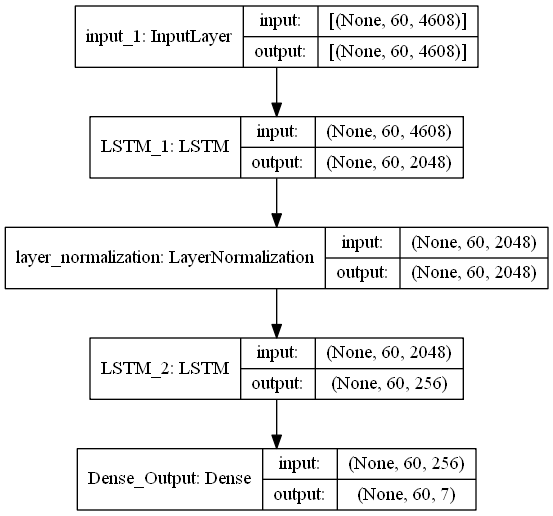

In [18]:
# Plot CNN-LSTM model
tf.keras.utils.plot_model(
    LSTM,
    to_file="images/models/LSTM_architecture.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

## Plot performance of model

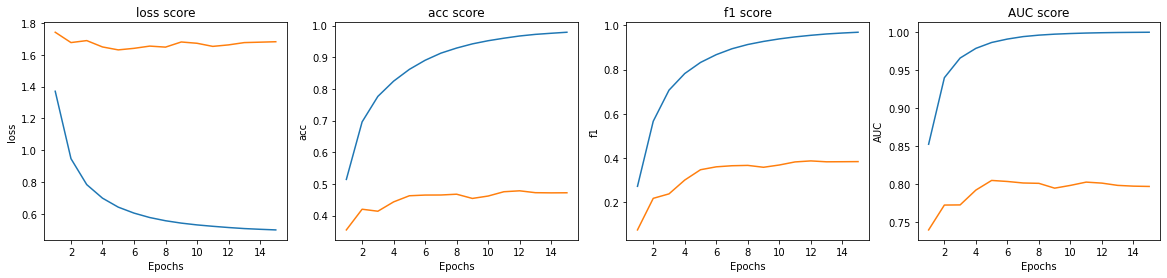

In [19]:
model_hist = history_best.history

labels = [*model_hist.keys()]
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
epochs = range(1, len(model_hist["loss"]) + 1)
for data, label in zip(
    [model_hist["loss"], model_hist["val_loss"]], [labels[0], labels[4]]
):
    axes[0].plot(epochs, data, label=label)

for data, label in zip(
    [model_hist["accuracy"], model_hist["val_accuracy"]], [labels[1], labels[5]]
):
    axes[1].plot(epochs, data, label=label)

for data, label in zip(
    [model_hist["f1"], model_hist["val_f1"]], [labels[2], labels[6]]
):
    axes[2].plot(epochs, data, label=label)

for data, label in zip(
    [model_hist["auc"], model_hist["val_auc"]], [labels[3], labels[7]]
):
    axes[3].plot(epochs, data, label=label)

for i, label in zip(range(4), ["loss", "acc", "f1", "AUC"]):
    axes[i].set_title(label + " score")
    axes[i].set_xlabel("Epochs")
    axes[i].set_ylabel(label)

In [21]:
# Save model performance to json file
with open("data/models/LSTM_performance.json", "w") as fp:
    json.dump(model_hist, fp)

## Save model+weights to folder

In [23]:
# Save model
tf.keras.Model.save(LSTM, filepath="data/models/LSTM_model.h5")

## Calculate precision score with SKlearn

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_auc_score

In [ ]:
# Do predictions on test set
val_predv2 = v2.predict(seq_val_features, verbose=0)

# Reshape back to (frame, label)
val_predv2 = np.reshape(
    val_predv2, (val_predv2.shape[0] * val_predv2.shape[1], val_predv2.shape[2])
)

# Convert one hot encoding to integers
val_predv2 = np.argmax(val_predv2, axis=1)

In [ ]:
# Reshape back to (frame, label)
val_true = np.reshape(
    seq_val_labels,
    (seq_val_labels.shape[0] * seq_val_labels.shape[1], seq_val_labels.shape[2]),
)
val_true = np.argmax(val_true, axis=1)

In [ ]:
# F1 Results with model v3
for avg in [None, "micro", "macro", "weighted"]:
    score = f1_score(val_true, val_predv3, average=avg)
    print(f"Average method: {avg}, f1-score: {score}")